In [33]:
import sunpy.map
import sunpy.visualization.colormaps as cm
import sunpy.sun.constants
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk
from sunpy.image.resample import resample

import astropy.units as u
from astropy.constants import G, M_sun, R_sun, au
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy.units import imperial
from astropy.stats import gaussian_fwhm_to_sigma

import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import plotly.tools as tls
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import pickle
import numpy as np
import pandas as pd
import math
from math import pi
import glob
import time
import datetime
import os
import importlib
import warnings
import cupy as cp

from PIL import Image
from fpdf import FPDF

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# Save 1400 maps into a df

I want to construct a df of two col:   time    image(numpy array)


Because win doesn't support cuDF, I have to use pandas.
pandas don't support cupy array.

In [3]:
aia_files=sorted(glob.glob('./data/AIA_1p5/*adjusted.fits'))
len(aia_files)

1352

In [5]:
#expected run time: 7 min
#loop through all files and extract time and image data, then save to a dataframe
df=pd.DataFrame(columns=['time','image'])
time_list=[]
image_list=[]

prob_list=[]

for i in list(range(len(aia_files)))[:]:
    smap=sunpy.map.Map(aia_files[i])
    t=smap.meta['date-obs']
    t=pd.to_datetime(t)
    time_list.append(t)

    image=smap.data
    #downsample image from (4096,4096) into (2048,2048) 
    image=resample(image,(2048,2048),method='linear',center=False,minusone = False)


    #turn dtype into float16: Range: Approximately ±65504 to ±5.96 × 10^-8
    image=image.astype(np.float16)
    image_list.append(image)


df['time']=time_list
df['image']=image_list
df['filename']=aia_files



In [7]:
with open('./data/aia_df_day.pkl', 'wb') as f:
    pickle.dump(df, f)

In [9]:
with open('./data/aia_df_day.pkl', 'rb') as f:
    aia_df=pickle.load(f)

In [10]:
aia_df

,time,image,filename
0,2011-01-01 00:00:08.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2011_01_01t00_00_...
1,2011-01-01 00:00:20.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2011_01_01t00_00_...
2,2011-01-01 00:00:32.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2011_01_01t00_00_...
3,2011-01-01 00:00:44.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2011_01_01t00_00_...
4,2011-01-01 00:00:56.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2011_01_01t00_00_...
...,...,...,...
1347,2011-01-01 05:24:44.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2011_01_01t05_24_...
1348,2011-01-01 05:24:56.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2011_01_01t05_24_...
1349,2011-01-01 05:25:32.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2011_01_01t05_25_...
1350,2011-01-01 05:25:44.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2011_01_01t05_25_...


# Similarity

In [80]:
aia_df['image'][i].dtype

dtype('float16')

In [132]:
# cupy version of
# https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.mean_squared_error

n=len(aia_df)
# n=100
mse_matrix=np.full((n,n),np.nan)
for i in range(n):
    img1=cp.asarray(aia_df['image'][i],dtype=cp.float32)
    for j in np.arange(i,n):
        
        img2=cp.asarray(aia_df['image'][j],dtype=cp.float32)
        mse_matrix[i,j]=cp.mean((img1-img2)**2)

mse_matrix=cp.asnumpy(mse_matrix)
np.savez('./data/mse_matrix_day.npz',mse_matrix=mse_matrix)

In [135]:
file=np.load('./data/mse_matrix_day.npz')
mse_matrix=file['mse_matrix']

In [139]:
time_list

[Timestamp('2011-01-01 00:00:08.120000'),
 Timestamp('2011-01-01 00:00:20.120000'),
 Timestamp('2011-01-01 00:00:32.120000'),
 Timestamp('2011-01-01 00:00:44.120000'),
 Timestamp('2011-01-01 00:00:56.120000'),
 Timestamp('2011-01-01 00:01:08.120000'),
 Timestamp('2011-01-01 00:01:20.120000'),
 Timestamp('2011-01-01 00:01:32.120000'),
 Timestamp('2011-01-01 00:01:44.120000'),
 Timestamp('2011-01-01 00:01:56.120000'),
 Timestamp('2011-01-01 00:02:08.120000'),
 Timestamp('2011-01-01 00:02:20.130000'),
 Timestamp('2011-01-01 00:02:32.120000'),
 Timestamp('2011-01-01 00:02:44.130000'),
 Timestamp('2011-01-01 00:02:56.120000'),
 Timestamp('2011-01-01 00:03:08.120000'),
 Timestamp('2011-01-01 00:03:20.140000'),
 Timestamp('2011-01-01 00:03:44.130000'),
 Timestamp('2011-01-01 00:03:56.130000'),
 Timestamp('2011-01-01 00:04:08.130000'),
 Timestamp('2011-01-01 00:04:20.120000'),
 Timestamp('2011-01-01 00:04:32.120000'),
 Timestamp('2011-01-01 00:04:44.120000'),
 Timestamp('2011-01-01 00:04:56.12

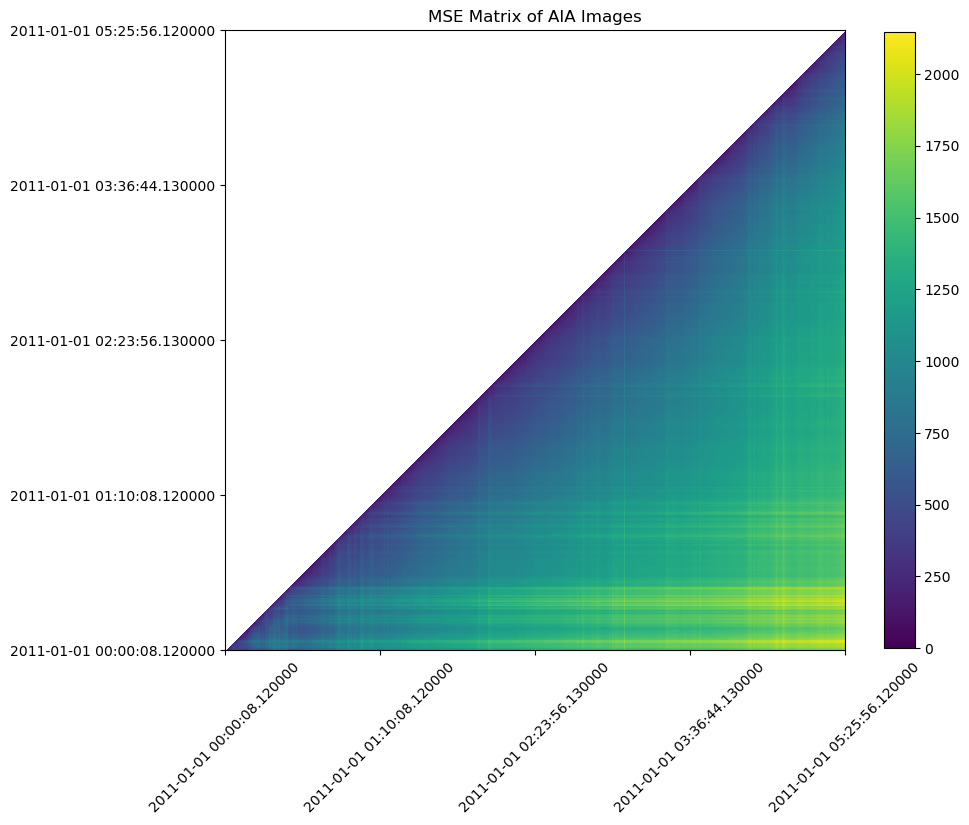

In [145]:
fig,ax=plt.subplots(figsize=(10,10))
im=ax.imshow(mse_matrix,origin='lower')

# set x,y tick to be time list
x_tick_list=np.linspace(0,n-1,5,dtype=int)
x_tick_label=[time_list[i].to_pydatetime() for i in x_tick_list]
ax.set_xticks(x_tick_list)
ax.set_xticklabels(x_tick_label,rotation=45)

y_tick_list=np.linspace(0,n-1,5,dtype=int)
y_tick_label=[time_list[i].to_pydatetime() for i in y_tick_list]
ax.set_yticks(y_tick_list)
ax.set_yticklabels(y_tick_label)

# set title
ax.set_title('MSE Matrix of AIA Images')

fig.colorbar(im,ax=ax,shrink=0.8)
fig.savefig('./fig/mse_matrix.png',dpi=3000)

In [114]:
%%timeit
img1=cp.asarray(aia_df['image'][i],dtype=cp.float32)
img2=cp.asarray(aia_df['image'][j],dtype=cp.float32)
cp.mean((img1-img2)**2)

16.6 ms ± 315 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [122]:
%%timeit
img1=aia_df['image'][i];        img2=aia_df['image'][j]
mean_squared_error(img1,img2)

23.1 ms ± 444 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
a= ssim(img1, img2,data_range=np.max(np.array([img2,img1]))-np.min(np.array([img2,img1])))

In [17]:
b=mean_squared_error(img1,img2)

In [26]:
## get a ssim matrix for all images

ssim_matrix=np.full((len(aia_df),len(aia_df)),np.nan)

for i in range(len(aia_df)):
    print(i)
    for j in np.arange(i,len(aia_df)):

        img1=aia_df['image'][i]
        img2=aia_df['image'][j]
        ssim_matrix[i,j]=ssim(img1, img2,
                              data_range=np.max(np.array([img2,img1]))-np.min(np.array([img2,img1])))
        


0


KeyboardInterrupt: 

In [43]:
# n=len(aia_df)
n=100
mse_matrix=np.full((n,n),np.nan)

for i in range(n):
    print(i)
    for j in np.arange(i,n):

        img1=aia_df['image'][i]
        img2=aia_df['image'][j]
        mse_matrix[i,j]=mean_squared_error(img1,img2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
# no resample

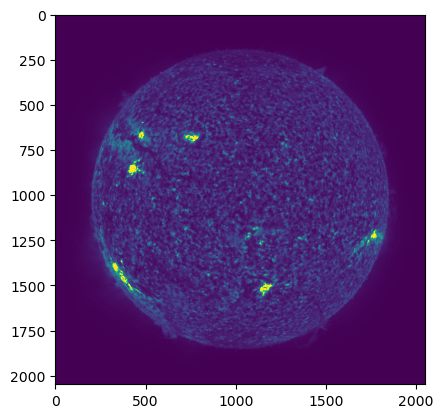

In [53]:
plt.imshow(img1,vmax=400)

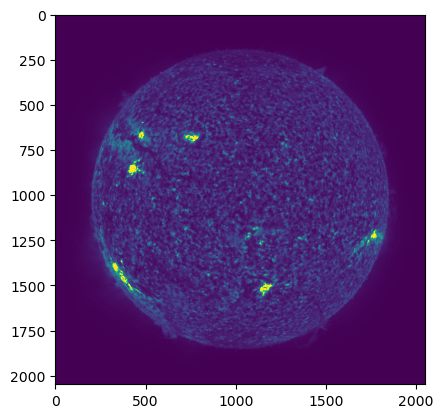

In [52]:
plt.imshow(img2,vmax=400)

In [55]:
%%timeit

img1=aia_df['image'][i]
img2=aia_df['image'][j]
ssim_matrix[i,j]=ssim(img1, img2,
data_range=np.max(np.array([img2,img1]))-np.min(np.array([img2,img1])))

485 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%%timeit 

img1=aia_df['image'][i]
img2=aia_df['image'][j]
ssim_matrix[i,j]=mean_squared_error(img1, img2)

27.1 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [97]:
%%timeit

cp.mean((cp.asarray(img1,dtype=cp.float64)-cp.asarray(img2,dtype=cp.float64))**2)

1.06 ms ± 5.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [107]:
# solve x*1400**2/1000/3600=6
x=6*1000*3600/1400**2
x

11.020408163265307

In [ ]:
# with resample

In [73]:
%%timeit imgi=resample(img1,(512,512));imgj=resample(img2,(512,512))

# img1=aia_df['image'][i]
# img2=aia_df['image'][j]
ssim_matrix[i,j]=mean_squared_error(imgi, imgj)

1.03 ms ± 27 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [74]:
%%timeit imgi=resample(img1,(1024,1024));imgj=resample(img2,(1024,1024))

# img1=aia_df['image'][i]
# img2=aia_df['image'][j]
ssim_matrix[i,j]=mean_squared_error(imgi, imgj)

4.59 ms ± 399 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
%%timeit imgi=resample(img1,(512,512));imgj=resample(img2,(512,512))

# img1=aia_df['image'][i]
# img2=aia_df['image'][j]
ssim_matrix[i,j]=ssim(imgi, imgj,
data_range=np.max(np.array([imgi,imgj]))-np.min(np.array([imgi,imgj])))

31.6 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
%%timeit imgi=resample(img1,(256,256));imgj=resample(img2,(256,256))

# img1=aia_df['image'][i]
# img2=aia_df['image'][j]
ssim_matrix[i,j]=ssim(imgi, imgj,
data_range=np.max(np.array([imgi,imgj]))-np.min(np.array([imgi,imgj])))

4.08 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [72]:
4*1400**2/1000/3600

2.1777777777777776

In [ ]:
img1.astype(np.int32)